In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
import os
from math import pi

SAMPLE_SIZE = 10000

%matplotlib inline
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable


## Preprocessing
Matteo

In [19]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def __types_file__(self):
        return 'types/' + self.name() +'.npy'
        
    def save_types(self):
        np.save(self.__types_file__(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.__types_file__()):
            self.types = np.load(self.__types_file__(),allow_pickle='TRUE').item()
            return self.types
        return None
    
    def col(self,columns:list, index:bool=True,**pd_params)->pd.DataFrame:
        """Loads some columns of the dataframe out of the whole csv file
        
        :param columns: a list of the desired columns
        :type columns: list
        :param index: if True loads also the 'sid' column as the index
        :type index: bool
        :param **pd_params: any other params for pd.read_csv(...)
        :rtype: pd.DataFrame
        """
        col_list = columns
        if 'cts' in col_list:
            pd_params['parse_dates'] = ['cts']
        if index :
            col_list.append('sid')
        return pd.read_csv(self.file_name,
                           usecols=col_list,
                           dtype=self.types, 
                           index_col='sid' if index else None,
                           delimiter='\t', 
                           **pd_params)

datasets = [
    Dataset(file='instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='instagram-dataset/instagram_locations.csv'), 
    Dataset(file='instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

Columns and inferred types from descrption 
TODO DESCRIBE MORE

In [20]:
profiles.types = {
#     'sid' : 'Int64',
    'profile_id' : 'Int64',
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : 'Int64',
    'followers' : 'Int64',
    'n_posts' : 'Int64',
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'sid_profile' : 'Int64',
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : 'Int64',
    'location_id' : 'Int64',
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : 'Int64',
    'number_comments' : 'Int64'
}
locations.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'id' : 'Int64',
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [21]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    print(delimiter)
    for chunk in pd.read_csv(file_path, 
                             usecols=[column],
                             delimiter=delimiter,
                             chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

Optimize types

In [27]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v == 'Int64']
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
    ds.save_types()

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

instagram_profiles  mean optimized memory usage per entry:  150 B vs  545 B  : 27.56%


ValueError: Unable to parse string "c2928474" at position 1779

## RQ1 - EDA
Andrea

#### Profiles 
| Field | Description |
|---|---|
| SID | Sequence ID |
| profile_id | Instagrams ID |
| profile_name | profile name |
| firstname_lastname | firstname lastname |
| description | May contain '\n' |
| following | Number of following profile at the moment it was visited |
| followers | Number of followers at the moment it was visited |
| n_posts | Number of posts at the moment it was visited |
| url | Url in profile description |
| cts | Timestamp when the profile was visited |
| is_business_account | Boolean flag if that profile was makred by the owner as business account |

#### Locations

| Field | Description |
|---|---|
| SID | Sequence ID |
| ID | Instagrams ID |
| Name | Locations Name |
| Street | Street Address, may contain '\n' |
| ZIP | Zip code |
| City | City Name |
| Region | Region |
| CD | Country Code |
| Phone | The phone in format as on the Instragram |
| aj_exact_city_match | The Instagrams Internal key |
| aj_exact_country_match | The Instagrams Internal key |
| blurb | Description of the place, may contain '\n' |
| dir_city_id | The Instagrams internal City ID |
| dir_city_name | city Name |
| dir_city_slug | City tag (sortof) |
| dir_country_id | Country ID |
| dir_country_name | country |
| lat | Latitude |
| lng | Longtitude |
| primary_alias_on_fb | Bool Flag |
| slug | ??? |
| website | The URL to web site, may contain more then 1 URL, may contain '\n' |
| cts | Timestamp when the location was visited |

#### Posts
| Field | Description |
|---|---|
| SID | Sequence ID |
| sid_profile | Sequence ID of the profile from *Profiles* table |
| post_id | Instagrams ID |
| profile_id | Instagrams ID may be null |
| location_id | Instagrams ID |
| cts | Timestamp when the Post was created |
| post_type | 1 - Photo, 2 - Video, 3 - multy |
| description | May contain '\n' |
| number_likes | Number of Likes at the moment it was visited |
| number_comments | Number of comments at the moment it was visited |

## RQ2
Carolina

## RQ3 - Time



### What is the most common time in which users publish their posts?

In [24]:
time = posts.col(['cts'], index=False, nrows=10000)

/tmp/ipykernel_9511/2556015344.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hours = hours.iloc[-N//4-1:].append(hours.iloc[:-N//4-1])


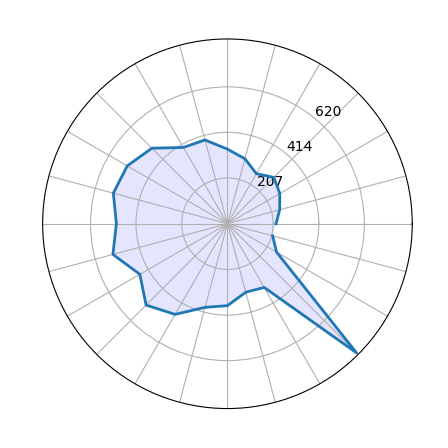

In [28]:
time['hour'] = time['cts'].map(lambda x: x.hour).astype('Int8')

def clock_graph(hours: pd.Series, labels:list=None):
    N = len(hours)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    hours = hours.iloc[-N//4-1:].append(hours.iloc[:-N//4-1])
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels
    labels = labels if labels is not None else hours.index
    plt.xticks(angles, labels, color='white', size=15)

    # Draw ylabels
    ax.set_rlabel_position(50)
    M = hours.max()
    ticks = list(map(round, [M/4, M/2, M*3/4]))
    plt.yticks(ticks, list(map(str, ticks)), color="black", size=10)
    plt.ylim(0,M+10)

    # Plot data
    ax.plot(angles, hours, linewidth=2, linestyle='solid')

    # Fill area
    ax.fill(angles, hours, 'b', alpha=0.1)

hours = time.hour.value_counts(sort=False).sort_index(ascending=False).to_frame()

clock_graph(hours.hour)

#### Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

In [71]:
def inter(h,inters):
    assert inters[0] == 0 and inters[-1]==24, 'Intervals list must start at 0 and end at 24'
    for i in range(len(inters) - 1):
        if h >= inters[i] and h < inters[i+1]:
            return i
        
def plot_intervals(hours_count, inters=range(0,25,4)):
    """A radarplot with the hours divided into intervals
    :hours_count: a dataframe where index is the hours and a 'hours' column which has the hours count
    :inters: a sorted list of hours breakpoints, starting at 1 and ending at 24
    """
    hours_count['intervals'] = hours_count.index.to_series().apply(
        lambda h :inter(h, inters)
    )
    clock_graph(hours.groupby(by='intervals').sum().hour)

#### Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

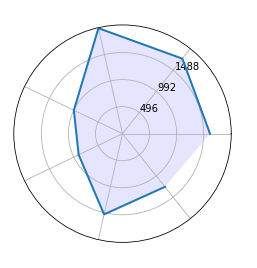

In [72]:
plot_intervals(hours, [0,3,6,11,14,17,20,24])

In [ ]:
del time
del hours

## RQ4
Andrea

## RQ5
Carolina

## RQ6
Matteo

## RQ7
Andrea

## RQ8
Carolina